<div align="center">
    
<br>

# FINE-GRAINED EMOTIONAL CONTROL OF TEXT-TO-SPEECH 

### LEARNING TO RANK INTER- AND INTRA-CLASS EMOTION INTENSITIES

Shijun Wang, Jón Guðnason, Damian Borth

**ICASSP 2023**

<br>

---

<br>

</div>

In [2]:
##############################################
# 1. Paths
##############################################
DATA_PATH           = '/workspace/data/EmoV-DB'
CORPUS_PATH         = '/workspace/montreal_forced_aligner/corpus'
TEXTGRID_PATH       = '/workspace/montreal_forced_aligner/aligned'
PREPROCESSED_PATH   = '/workspace/preprocessed'


##############################################
# 2. Preprocessing
##############################################
NOISE_SYMBOL        = ' [noise] '
SPEAKERS            = ['bea', 'jenie', 'josh', 'sam']
EMOTIONS            = ['neutral', 'amused', 'angry', 'disgusted', 'sleepy']
SIL_PHONES          = ['sil', 'spn', 'sp', '']
PITCH_AVERAGING     = True
ENERGY_AVERAGING    = True


##############################################
# 3. Audio (optimized for vocoder)
##############################################
SAMPLING_RATE       = 16000
HOP_LENGTH          = 256
WIN_LENGTH          = 1024
N_FFT               = 1024
N_MELS              = 80
F_MIN               = 0.0
F_MAX               = 8000.0

In [8]:
import os
import tgt
import glob
import tqdm
import json
import torch
import scipy
import librosa
import torchaudio
import numpy as np
import pyworld as pw
import matplotlib.pyplot as plt

from text import _clean_text
from sklearn.preprocessing import StandardScaler
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

#### **1. Preprocessing**



In [4]:
audio_id_to_transcript = {}

with open(os.path.join(DATA_PATH, 'cmuarctic.data')) as f:
    for line in f.readlines():
        audio_id, transcript = line[2:-2].split('\"')[:2]

        audio_id = audio_id.strip()
        transcript = transcript.strip()

        if audio_id.startswith('arctic_b'):
            continue
        
        audio_id = audio_id[-4:]
        transcript = NOISE_SYMBOL + _clean_text(transcript, ['english_cleaners']) + NOISE_SYMBOL

        audio_id_to_transcript[audio_id] = transcript.strip()

In [ ]:
for speaker in tqdm.tqdm(SPEAKERS):
    for emotion in EMOTIONS:

        # check the path existence: josh has only three emotions
        spk_emo_path = os.path.join(DATA_PATH, speaker, emotion)
        if not os.path.exists(spk_emo_path):
            continue
        
        # resample and create .lab file
        for wav_path in glob.glob(os.path.join(spk_emo_path, '*.wav')):

            y, sr = librosa.load(wav_path, sr=SAMPLING_RATE)

            audio_id = os.path.basename(wav_path)[:-4]
            transcript = audio_id_to_transcript[audio_id]

            os.makedirs(os.path.join(CORPUS_PATH, speaker), exist_ok=True)

            tgt_path = os.path.join(CORPUS_PATH, speaker, f'{emotion}_{audio_id}')
            scipy.io.wavfile.write(tgt_path + '.wav', sr, y)

            with open(tgt_path + '.lab', 'w') as f:
                f.write(transcript + '\n')


In [ ]:
# download speech dictionary
wget -O /workspace/montreal_forced_aligner/librispeech-lexicon.txt https://openslr.trmal.net/resources/11/librispeech-lexicon.txt 

# prepare environment for montreal forced aligner
conda create -n aligner -c conda-forge montreal-forced-aligner -y

# **important** please make sure to select `aligner` environment
mfa model download acoustic english_us_arpa
mfa validate /workspace/montreal_forced_aligner/corpus /workspace/montreal_forced_aligner/librispeech-lexicon.txt english_us_arpa
mfa align /workspace/montreal_forced_aligner/corpus /workspace/montreal_forced_aligner/librispeech-lexicon.txt english_us_arpa /workspace/montreal_forced_aligner/aligned

In [5]:
def process_textgrid(textgrid_file):

    phones = []
    durations = []
    speech_start_time = 0.0
    speech_end_time = 0.0
    end_idx = 0

    tg = tgt.io.read_textgrid(textgrid_file, include_empty_intervals=True)
    tier = tg.get_tier_by_name('phones')

    for t in tier._objects:
        
        s, e, p = t.start_time, t.end_time, t.text

        if len(phones) == 0:
            if p in SIL_PHONES:
                continue
            speech_start_time = s

        if p not in SIL_PHONES:
            phones.append(p)
            speech_end_time = e
            end_idx = len(phones)
        else:
            phones.append('spn')

        durations.append(
            int(
                np.round(e * SAMPLING_RATE / HOP_LENGTH) -
                np.round(s * SAMPLING_RATE / HOP_LENGTH)
            )
        )

    phones = phones[:end_idx]
    durations = durations[:end_idx]

    return phones, durations, speech_start_time, speech_end_time


def trim_audio(y, start_time, end_time):
    start_idx = int(np.round(start_time * SAMPLING_RATE))
    end_idx = int(np.round(end_time * SAMPLING_RATE))

    y = y[start_idx:end_idx].astype(np.float32)
    return y


def get_pitch(y):
    y = y.astype(np.float64)
    f0, t = pw.dio(y, SAMPLING_RATE, frame_period=HOP_LENGTH / SAMPLING_RATE * 1000)
    f0 = pw.stonemask(y, f0, t, SAMPLING_RATE)
   
    return f0


def get_mel(y):
    y = torch.FloatTensor(y)
    mel, energy = mel_spectogram(
        audio=y,
        sample_rate=SAMPLING_RATE,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        n_fft=N_FFT,
        f_min=F_MIN,
        f_max=F_MAX,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )
    return mel, energy


def expand(values, durations):
    out = list()
    for value, d in zip(values, durations):
        out += [value] * max(0, int(d))
    return np.array(out)

In [6]:
def feature_extraction(speaker, emotion, tbar):

    @staticmethod
    def _remove_outliers(x):
        p25 = np.percentile(x, 25)
        p75 = np.percentile(x, 75)
        lower = p25 - 1.5 * (p75 - p25)
        upper = p75 + 1.5 * (p75 - p25)
        normal_indices = np.logical_and(x >= lower, x <= upper)
        return x[normal_indices]


    # z-score normalization & return min/max values
    @staticmethod
    def _normalize(name, mean, std):
        
        max_value = np.finfo(np.float64).min
        min_value = np.finfo(np.float64).max

        for preprocessed_path in glob.glob(os.path.join(PREPROCESSED_PATH, speaker, f'{emotion}_*.npz')):
            data = dict(np.load(preprocessed_path))

            data[name] = (data[name] - mean) / std
            np.savez(preprocessed_path, **data)

            max_value = max(max_value, max(data[name]))
            min_value = min(min_value, min(data[name]))

        return min_value, max_value


    # scaler for pitch and energy
    pitch_scaler = StandardScaler()
    energy_scaler = StandardScaler()

    for audio_path in glob.glob(os.path.join(CORPUS_PATH, speaker, f'{emotion}_*.wav')):

        tbar.update(1)

        audio_id = os.path.basename(audio_path)[:-4].split('_')[-1]
        textgrid_path = os.path.join(TEXTGRID_PATH, speaker, f'{emotion}_{audio_id}.TextGrid')
        transcript_path = os.path.join(CORPUS_PATH, speaker, f'{emotion}_{audio_id}.lab')

        # check the path existence
        if not os.path.exists(textgrid_path):
            continue

        phones, durations, speech_start_time, speech_end_time = process_textgrid(textgrid_path)

        if speech_start_time >= speech_end_time:
            print(f"Invalid start/end: {audio_path}")

        # trim audio
        y, sr = librosa.load(audio_path, sr=SAMPLING_RATE)
        y = trim_audio(y, speech_start_time, speech_end_time)

        # transcript
        with open(transcript_path, 'r') as f:
            transcript = f.read().strip().replace(NOISE_SYMBOL, '')

        # 1. pitch
        pitch = get_pitch(y)
        if np.sum(pitch != 0) <= 1:
            print(f"Invalid pitch: {audio_path}")
            continue
        pitch = pitch[:sum(durations)]
        
        # 2. melspectrogram, energy
        mel, energy = get_mel(y)
        mel = mel.numpy()
        energy = energy.numpy()
        mel = mel[:, :sum(durations)]
        energy = energy[:sum(durations)]


        if PITCH_AVERAGING:
            nonzero_ids = np.where(pitch != 0)[0]
            interp_fn = scipy.interpolate.interp1d(
                nonzero_ids,
                pitch[nonzero_ids],
                kind='linear',
                fill_value=(pitch[nonzero_ids[0]], pitch[nonzero_ids[-1]]),
                bounds_error=False  
            )
            pitch = interp_fn(np.arange(len(pitch)))

            pos = 0
            for i, d in enumerate(durations):
                if d > 0:
                    pitch[i] = np.mean(pitch[pos:pos + d])
                else:
                    pitch[i] = 0
                pos += d
            pitch = pitch[:len(durations)]

        if ENERGY_AVERAGING:
            pos = 0
            for i, d in enumerate(durations):
                if d > 0:
                    energy[i] = np.mean(energy[pos:pos + d])
                else:
                    energy[i] = 0
                pos += d
            energy = energy[:len(durations)]

        
        # remove outliers
        outlier_removed_pitch = _remove_outliers(pitch)
        outlier_removed_energy = _remove_outliers(energy)

        pitch_scaler.partial_fit(outlier_removed_pitch.reshape((-1, 1)))
        energy_scaler.partial_fit(outlier_removed_energy.reshape((-1, 1)))


        # save artifacts
        np.savez(
            os.path.join(PREPROCESSED_PATH, speaker, f'{emotion}_{audio_id}.npz'),
            
            # metadata
            phones=phones,
            emotion=emotion,
            speaker=speaker,
            audio_id=audio_id,
            audio_path=audio_path,
            transcript=transcript,
            textgrid_path=textgrid_path,
            
            # inputs
            mel=mel,
            pitch=pitch,
            energy=energy,
            durations=durations,
        )

    pitch_mean, pitch_std = pitch_scaler.mean_[0], pitch_scaler.scale_[0]
    energy_mean, energy_std = energy_scaler.mean_[0], energy_scaler.scale_[0]

    pitch_min, pitch_max = _normalize('pitch', pitch_mean, pitch_std)
    energy_min, energy_max = _normalize('energy', energy_mean, energy_std)

    if os.path.exists(os.path.join(PREPROCESSED_PATH, 'stats.json')):
        with open(os.path.join(PREPROCESSED_PATH, 'stats.json'), 'r') as f:
            stats = json.load(f)
    else:
        stats = {}
    
    with open(os.path.join(PREPROCESSED_PATH, 'stats.json'), 'w') as f:
        new_stats = {
            'pitch': [float(pitch_min), float(pitch_max), float(pitch_mean), float(pitch_std)],
            'energy': [float(energy_min), float(energy_max), float(energy_mean), float(energy_std)],
        }
        stats[speaker] = {}
        stats[speaker][emotion] = new_stats
        json.dump(stats, f, indent=4)


In [7]:
tbar = tqdm.notebook.tqdm(total=len(glob.glob(os.path.join(CORPUS_PATH, '*', '*.wav'))), desc='Processing EmoV-DB')
tbar.n = 0

for speaker in SPEAKERS:

    for emotion in EMOTIONS:

        # check the path existence
        if not os.path.exists(os.path.join(DATA_PATH, speaker, emotion)):
            continue

        # preprocessed path
        os.makedirs(os.path.join(PREPROCESSED_PATH, speaker), exist_ok=True)

        # mel, energy, pitch, durations
        feature_extraction(speaker, emotion, tbar)

/tmp/ipykernel_10186/3962163910.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tbar = tqdm.tqdm_notebook(total=len(glob.glob(os.path.join(CORPUS_PATH, '*', '*.wav'))), desc='Processing EmoV-DB')


Processing EmoV-DB:   0%|          | 0/6888 [00:00<?, ?it/s]

Invalid pitch: /workspace/montreal_forced_aligner/corpus/josh/sleepy_0054.wav


#### **2. Utility**

In [ ]:
# plot only one melspectrogram
def plot_melspectrogram(mel, save_path=None):

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(mel, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel bands')
    ax.set_title('Melspectrogram')

    cbar = fig.colorbar(im, ax=ax, format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    

# plot melspectrograms for GT and predicted
def plot_melspectrograms(mel_gt, mel_pred, save_path=None):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    axes[0].imshow(mel_gt, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    axes[0].set_title('Ground Truth Melspectrogram')
    axes[0].set_xlabel('Time (frames)')
    axes[0].set_ylabel('Mel bands')

    axes[1].imshow(mel_pred, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    axes[1].set_title('Predicted Melspectrogram')
    axes[1].set_xlabel('Time (frames)')
    axes[1].set_ylabel('Mel bands')

    cbar = fig.colorbar(axes[0].images[0], ax=axes, format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)')

    fig.subplots_adjust(hspace=0.6, right=0.75)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# !FIX HERE
# plot all features: mel, pitch, energy
def plot_features(mel, ex_pitch, ex_energy, save_path=None):

    @staticmethod
    def add_axis(fig, ax):
        ax1 = fig.add_axes(ax.get_position(), anchor='W')
        ax1.set_facecolor('none')
        return ax1
    
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(mel, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    ax.set_aspect(2.5, adjustable='box')
    ax.set_anchor('W')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel bands')
    ax.set_title('Melspectrogram')

    cbar = fig.colorbar(im, ax=ax, format='%+2.0f dB')
    cbar.set_label('Amplitude (dB)')

    ax1 = add_axis(fig, ax)
    ax1.plot(ex_pitch, color='tomato', label='Pitch', linewidth=1.5)
    ax1.set_ylabel('Pitch (Hz)', color='tomato')
    ax1.tick_params(labelsize='x-small', colors='tomato', bottom=False, labelbottom=False)
    
    ax2 = add_axis(fig, ax)
    ax2.plot(ex_energy, color='darkviolet', label='Energy', linewidth=1.5)
    ax2.set_ylabel('Energy (dB)')
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(labelsize='x-small', colors='darkviolet', bottom=False, labelbottom=False, 
                    left=False, labelleft=False, right=True, labelright=True)

    # plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

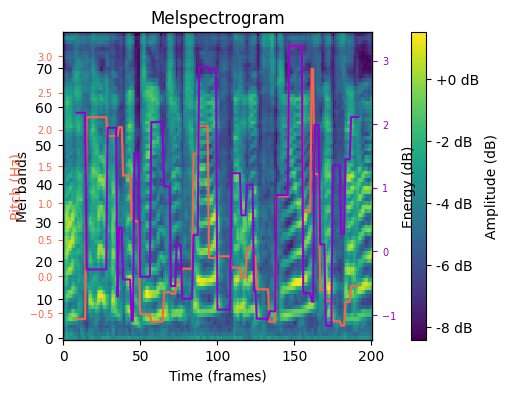

In [77]:
bea_amused_0001 = np.load(os.path.join(PREPROCESSED_PATH, 'bea', 'amused_0001.npz'), allow_pickle=True)
bea_amused_0001_mel = dict(bea_amused_0001)['mel']
bea_amused_0001_pitch = dict(bea_amused_0001)['pitch']
bea_amused_0001_energy = dict(bea_amused_0001)['energy']
bea_amused_0001_durations = dict(bea_amused_0001)['durations']

# plot_melspectrogram(bea_amused_0001_mel)
# plot_melspectrograms(bea_amused_0001_mel, bea_amused_0001_mel)
ep_pitch = expand(bea_amused_0001_pitch, bea_amused_0001_durations)
ep_energy = expand(bea_amused_0001_energy, bea_amused_0001_durations)
plot_features(bea_amused_0001_mel, ep_pitch, ep_energy)

In [ ]:
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

# Load a pretrained HIFIGAN Vocoder
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-16kHz", savedir="pretrained_models/tts-hifigan-libritts-16kHz")

# Load an audio file (an example file can be found in this repository)
# Ensure that the audio signal is sampled at 16000 Hz; refer to the provided link for a 22050 Hz Vocoder.
signal, rate = torchaudio.load('/workspace/montreal_forced_aligner/corpus/bea/amused_0001.wav')

# Ensure the audio is sigle channel
signal = signal[0].squeeze()

torchaudio.save('/workspace/waveform.wav', signal.unsqueeze(0), 16000)

# Compute the mel spectrogram.
# IMPORTANT: Use these specific parameters to match the Vocoder's training settings for optimal results.
spectrogram, _ = mel_spectogram(
    audio=signal.squeeze(),
    sample_rate=SAMPLING_RATE,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    n_fft=1024,
    f_min=0.0,
    f_max=8000.0,
    power=1,
    normalized=False,
    min_max_energy_norm=True,
    norm="slaney",
    mel_scale="slaney",
    compression=True
)

# Convert the spectrogram to waveform
waveforms = hifi_gan.decode_batch(spectrogram)

# Save the reconstructed audio as a waveform
torchaudio.save('/workspace/waveform_reconstructed.wav', waveforms.squeeze(1), 16000)

# If everything is set up correctly, the original and reconstructed audio should be nearly indistinguishable
